Loaded dataset:  (223092, 8)
Columns: Index(['segment_id', 'ppd_original_SpeciesName', 'Strand', 'segment',
       'class_label', 'L', 'prom_class', 'y'],
      dtype='object')


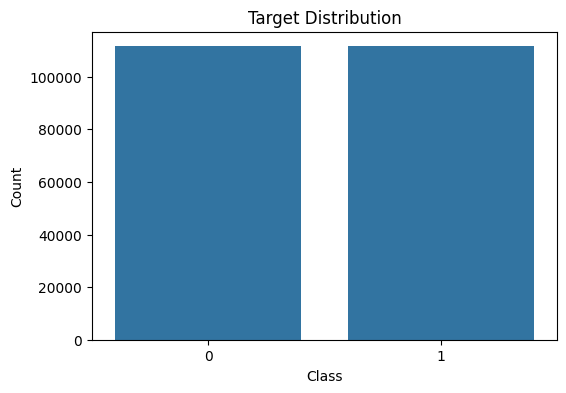

Train/Test split: (167319, 81, 4) (55773, 81, 4)
Epoch 1/10
1177/1177 - 23s - 20ms/step - accuracy: 0.6923 - loss: 0.5688 - val_accuracy: 0.7184 - val_loss: 0.5362
Epoch 2/10
1177/1177 - 21s - 18ms/step - accuracy: 0.7278 - loss: 0.5261 - val_accuracy: 0.7318 - val_loss: 0.5215
Epoch 3/10
1177/1177 - 20s - 17ms/step - accuracy: 0.7384 - loss: 0.5121 - val_accuracy: 0.7370 - val_loss: 0.5134
Epoch 4/10
1177/1177 - 22s - 18ms/step - accuracy: 0.7464 - loss: 0.5026 - val_accuracy: 0.7440 - val_loss: 0.5062
Epoch 5/10
1177/1177 - 22s - 19ms/step - accuracy: 0.7523 - loss: 0.4946 - val_accuracy: 0.7484 - val_loss: 0.4998
Epoch 6/10
1177/1177 - 20s - 17ms/step - accuracy: 0.7571 - loss: 0.4883 - val_accuracy: 0.7478 - val_loss: 0.5009
Epoch 7/10
1177/1177 - 22s - 18ms/step - accuracy: 0.7620 - loss: 0.4822 - val_accuracy: 0.7493 - val_loss: 0.5002
Epoch 8/10
1177/1177 - 20s - 17ms/step - accuracy: 0.7647 - loss: 0.4765 - val_accuracy: 0.7520 - val_loss: 0.4996
Epoch 9/10
1177/1177 - 21s - 18

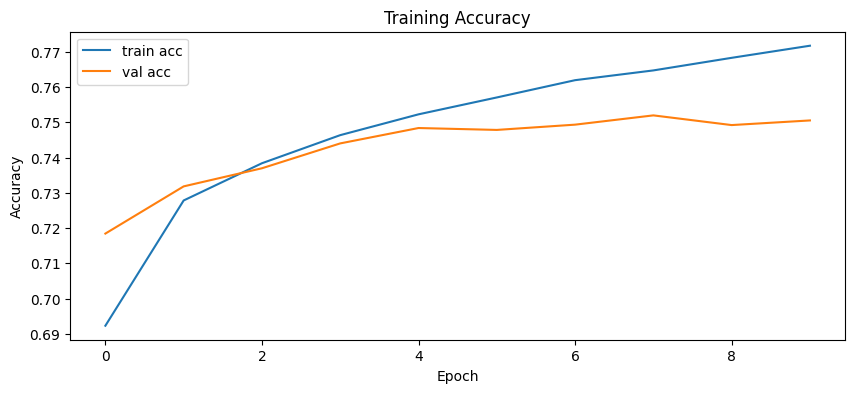

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sequence 1 → Class: 0, Probability of promoter: 0.2150
Sequence 2 → Class: 0, Probability of promoter: 0.2256


In [5]:
# ------------------- Imports -------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ------------------- Load & Prepare Dataset -------------------
def load_and_prepare_dataset(hf_dataset_name="neuralbioinfo/bacterial_promoters",
                             sequence_field="segment",
                             label_field="y"):

    ds = load_dataset(hf_dataset_name, split="train")
    df = ds.to_pandas()
    print("Loaded dataset: ", df.shape)
    print("Columns:", df.columns)

    # Convert sequences to one-hot arrays
    sequences = df[sequence_field].astype(str).tolist()
    labels = df[label_field].tolist()

    # Encode nucleotides to one-hot: A,C,G,T -> [1,0,0,0] etc
    mapping = {'A':0, 'C':1, 'G':2, 'T':3}
    max_len = len(sequences[0])  # assume all same length
    X = np.zeros((len(sequences), max_len, 4), dtype=np.float32)

    for i, seq in enumerate(sequences):
        for j, nuc in enumerate(seq):
            if nuc in mapping:
                X[i, j, mapping[nuc]] = 1.0

    # Encode labels
    y = np.array(labels)

    return X, y

# ------------------- Plot Target Distribution -------------------
def plot_target_distribution(y):
    plt.figure(figsize=(6,4))
    sns.countplot(x=y)
    plt.title("Target Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# ------------------- Build CNN Model -------------------
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=3),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ------------------- Train & Evaluate -------------------
def train_and_evaluate(X_train, X_test, y_train, y_test, epochs=10, batch_size=128):
    model = build_cnn_model(X_train.shape[1:])
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )

    # Evaluate on test set
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(10,4))
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return model

# ------------------- Main -------------------
if __name__ == "__main__":
    X, y = load_and_prepare_dataset()
    plot_target_distribution(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    print("Train/Test split:", X_train.shape, X_test.shape)

    cnn_model = train_and_evaluate(X_train, X_test, y_train, y_test)

# ------------------- Predict New Sequences -------------------
def predict_sequence(model, sequence):
    """
    Predict if a DNA sequence is a promoter or not.

    Args:
        model: Trained CNN model
        sequence: DNA string (e.g., "ATGCCGT...")

    Returns:
        predicted_class: 0 (non-promoter) or 1 (promoter)
        probability: probability of being promoter (1)
    """
    mapping = {'A':0, 'C':1, 'G':2, 'T':3}
    seq_len = model.input_shape[1]  # required length of the model input
    X = np.zeros((1, seq_len, 4), dtype=np.float32)

    # truncate or pad sequence if needed
    sequence = sequence.upper()
    sequence = sequence[:seq_len].ljust(seq_len, 'N')  # pad with 'N's if too short

    for j, nuc in enumerate(sequence):
        if nuc in mapping:
            X[0, j, mapping[nuc]] = 1.0

    prob = model.predict(X)[0,0]
    predicted_class = int(prob > 0.5)
    return predicted_class, prob

# ------------------- Example Usage -------------------
if __name__ == "__main__":
    # Example DNA sequences
    test_seq1 = "TTGACAGCTAGCTAGCTACGATGCGTATGCTAGCTAGCTTATAATGCGTAC"
    test_seq2 = "TTGACAAGCTGATCGTACGTAGCTAGCTAGCGTATGCTAGCTTATAATGC"

    pred1, prob1 = predict_sequence(cnn_model, test_seq1)
    pred2, prob2 = predict_sequence(cnn_model, test_seq2)

    print(f"Sequence 1 → Class: {pred1}, Probability of promoter: {prob1:.4f}")
    print(f"Sequence 2 → Class: {pred2}, Probability of promoter: {prob2:.4f}")